# <span style="color:slateblue"><b>Import Dependencies

In [1]:
# Imports
import pandas as pd
import numpy as np
import pickle
import scipy.stats as sp
from joblib import dump
import os

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import time
LOG_DIR = f"{int(time.time())}"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LeakyReLU

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

import sklearn as skl
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, balanced_accuracy_score, accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

# <span style="color:slateblue"><b>Data Load</span>

In [2]:
# file paths
file_path_Raw = "./Resources/cumulative.csv"
file_path_Pickles = "./Pickles/"

In [3]:
with open(file_path_Pickles+'kepler_processed.pkl', 'rb') as pickle_file:
    keplerProcessed_df= pickle.load(pickle_file)

In [4]:
keplerProcessed_df

,Exoplanet_Archive_Disposition,Not_Transit-Like_FPF,Stellar_Eclipse_FPF,Centroid_Offset_FPF,Ephemeris_Match_Indicates_Contamination_FPF,Orbital_Period_[days],Transit_Epoch_[BKJD],Impact_Parameter,Transit_Duration_[hrs],Transit_Depth_[ppm],...,TCE_Planet_Number,Stellar_Effective_Temperature_[K],Stellar_Surface_Gravity,Stellar_Radius_[Solar_radii],right_ascension,declination,Kepler_band [mag],TCE_Delivery_q1_q16_tce,TCE_Delivery_q1_q17_dr24_tce,TCE_Delivery_q1_q17_dr25_tce
K00752.01,1,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,...,1.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,0,0,1
K00752.02,1,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,...,2.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,0,0,1
K00753.01,2,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,...,1.0,5853.0,4.544,0.868,297.00482,48.134129,15.436,0,0,1
K00754.01,2,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,...,1.0,5805.0,4.564,0.791,285.53461,48.285210,15.597,0,0,1
K00755.01,1,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,...,1.0,6031.0,4.438,1.046,288.75488,48.226200,15.509,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K07984.01,2,0,0,0,1,8.589871,132.016100,0.765,4.80600,87.7,...,1.0,5638.0,4.296,1.088,298.74921,46.973351,14.478,0,0,1
K07985.01,2,0,1,1,0,0.527699,131.705093,1.252,3.22210,1579.2,...,1.0,5638.0,4.529,0.903,297.18875,47.093819,14.082,0,0,1
K07986.01,0,0,0,0,0,1.739849,133.001270,0.043,3.11400,48.5,...,1.0,6119.0,4.444,1.031,286.50937,47.163219,14.757,0,0,1
K07987.01,2,0,0,1,0,0.681402,132.181750,0.147,0.86500,103.6,...,1.0,6173.0,4.447,1.041,294.16489,47.176281,15.385,0,0,1


### Separate the Features (X) from the Target (y)

In [5]:
y = to_categorical(keplerProcessed_df["Exoplanet_Archive_Disposition"])
X = keplerProcessed_df.drop(["Exoplanet_Archive_Disposition"], axis =1)

### Split our data into training and testing

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(6708, 23)

### Scale data

In [7]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# <span style="color:slateblue"><b>NEURAL NET

In [8]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])

nn = tf.keras.models.Sequential()

# Input layer
nn.add(tf.keras.layers.Dense(units=260, input_dim=number_input_features, activation="relu"))

# First hidden layer
nn.add(tf.keras.layers.Dense(units=300, activation="relu"))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=80, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)


Epoch 1/100
210/210 [==============================] - ETA: 0s - loss: 1.0804 - accuracy: 0.43 - ETA: 0s - loss: 0.5304 - accuracy: 0.73 - ETA: 0s - loss: 0.4525 - accuracy: 0.77 - ETA: 0s - loss: 0.4305 - accuracy: 0.78 - ETA: 0s - loss: 0.4078 - accuracy: 0.79 - 0s 1ms/step - loss: 0.4030 - accuracy: 0.7923
Epoch 2/100
210/210 [==============================] - ETA: 0s - loss: 0.4116 - accuracy: 0.81 - ETA: 0s - loss: 0.3386 - accuracy: 0.83 - ETA: 0s - loss: 0.3512 - accuracy: 0.82 - ETA: 0s - loss: 0.3488 - accuracy: 0.82 - ETA: 0s - loss: 0.3436 - accuracy: 0.82 - 0s 978us/step - loss: 0.3436 - accuracy: 0.8251
Epoch 3/100
210/210 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.87 - ETA: 0s - loss: 0.3096 - accuracy: 0.83 - ETA: 0s - loss: 0.3192 - accuracy: 0.83 - ETA: 0s - loss: 0.3261 - accuracy: 0.83 - 0s 952us/step - loss: 0.3272 - accuracy: 0.8287
Epoch 4/100
210/210 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.84 - ETA: 0s 

In [9]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

70/70 - 0s - loss: 1.2055 - accuracy: 0.8471
Loss: 1.2055329084396362, Accuracy: 0.8471166491508484


<AxesSubplot:>

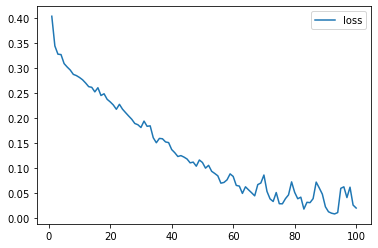

In [10]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

<AxesSubplot:>

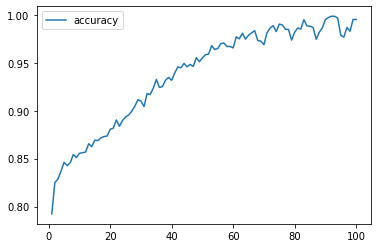

In [11]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [12]:
# Get the confusion matrix
y_pred = nn.predict(X_test_scaled)
y_pred=np.argmax(y_pred, axis=1)
y_testCM=np.argmax(y_test, axis=1)

cm_nn = confusion_matrix(y_testCM, y_pred)
cm_nn_df = pd.DataFrame(
   cm_nn, index=["Actual 0", "Actual 1", "Actual 2"],
   columns=["Predicted 0", "Predicted 1", "Predicted 2"]
)
cm_nn_df

,Predicted 0,Predicted 1,Predicted 2
Actual 0,378,141,15
Actual 1,165,395,12
Actual 2,3,6,1122


In [13]:
# Get Classification Report
print("Classification Report")
print(classification_report(y_testCM, y_pred ))

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       534
           1       0.73      0.69      0.71       572
           2       0.98      0.99      0.98      1131

    accuracy                           0.85      2237
   macro avg       0.80      0.80      0.80      2237
weighted avg       0.85      0.85      0.85      2237



# <span style="color:slateblue"><b>HYPERTUNING
    in RAW cells due to long runtimes

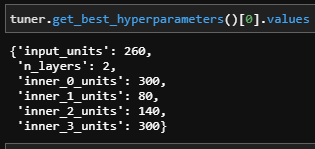

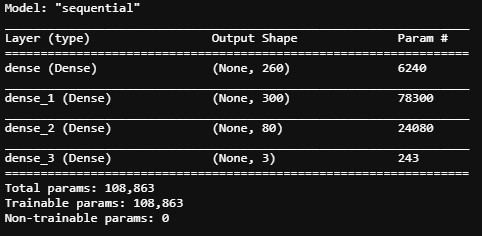

# <span style="color:slateblue"><b>NEURAL NET RESHAPING FOR THE WEB APPLICATION

### Cutting down some features and exporting the trained model and the scaler parameters

In [14]:
y = to_categorical(keplerProcessed_df["Exoplanet_Archive_Disposition"])
X = keplerProcessed_df.drop(["Exoplanet_Archive_Disposition","TCE_Planet_Number","right_ascension","declination","TCE_Delivery_q1_q16_tce","TCE_Delivery_q1_q17_dr24_tce","TCE_Delivery_q1_q17_dr25_tce"], axis =1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(6708, 17)

In [16]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [17]:
# # Exporting the parameters
# save_location=os.path.join("webapp","model","scaler_param.joblib")
# dump(scaler, save_location)

In [18]:
# Define the model - deep neural net (same parameters as above, just increasing the epochs)
number_input_features = X_train.shape[1]

nn = tf.keras.models.Sequential()

# Input layer
nn.add(tf.keras.layers.Dense(units=260, input_dim=number_input_features, activation="relu"))

# First hidden layer
nn.add(tf.keras.layers.Dense(units=300, activation="relu"))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=80, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train, y_train, epochs=200)

Epoch 1/200
210/210 [==============================] - ETA: 0s - loss: 661.5233 - accuracy: 0.28 - ETA: 0s - loss: 155.8837 - accuracy: 0.50 - ETA: 0s - loss: 140.7414 - accuracy: 0.51 - ETA: 0s - loss: 120.7701 - accuracy: 0.50 - ETA: 0s - loss: 110.7470 - accuracy: 0.50 - 0s 1ms/step - loss: 106.5716 - accuracy: 0.5004
Epoch 2/200
210/210 [==============================] - ETA: 0s - loss: 11.6549 - accuracy: 0.562 - ETA: 0s - loss: 16.4735 - accuracy: 0.503 - ETA: 0s - loss: 75.1353 - accuracy: 0.505 - ETA: 0s - loss: 75.8888 - accuracy: 0.521 - ETA: 0s - loss: 65.7754 - accuracy: 0.523 - 0s 1ms/step - loss: 67.5934 - accuracy: 0.5219
Epoch 3/200
210/210 [==============================] - ETA: 0s - loss: 450.3668 - accuracy: 0.46 - ETA: 0s - loss: 83.9057 - accuracy: 0.5255 - ETA: 0s - loss: 49.7958 - accuracy: 0.529 - ETA: 0s - loss: 164.4044 - accuracy: 0.51 - 0s 916us/step - loss: 150.0615 - accuracy: 0.5101
Epoch 4/200
210/210 [==============================] - ETA: 0s - loss: 24

In [19]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

70/70 - 0s - loss: 0.4478 - accuracy: 0.8350
Loss: 0.4477795660495758, Accuracy: 0.8350469470024109


<b>Small increase in accuracy: 0.857398271560669 vs. 0.8395172357559204 previously</b>

<AxesSubplot:>

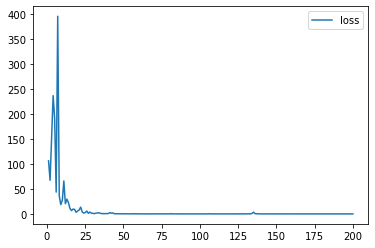

In [20]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

<AxesSubplot:>

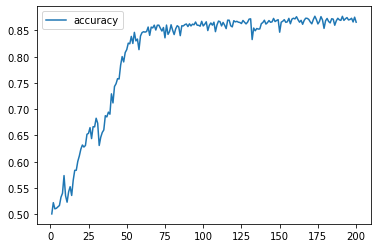

In [21]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [22]:
# # Export our model to HDF5 file
# save_location=os.path.join("webapp","model","kepler_NN.h5")
# nn.save(save_location)